In [1]:
#2000
import copy 
import os 
import itertools
from collections import Counter
import json
import pickle
import pprint
import pandas as pd
import numpy as np
res_dir = 'data-toggle/2000'
expdir = os.path.join(os.path.join(os.getcwd(), res_dir), 'causal_discovery')

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [6, 8]

# Utility Functions 

In [3]:
def dataset_name_from_unid(uid):
    if 'adult' in uid:
        return 'adult'
    if 'german' in uid:
        return 'germanCredit'
    
    assert True == False 

In [4]:
def get_hps_from_rawres(fname):
    '''rawres fname -> features'''
    unique_id = (fname.split('rawres_')[1]).split('.json')[0]
    alpha = unique_id.split('_')[0]
    feateng = unique_id.split('_')[1]
    dataset = unique_id.split('_')[2]
    seed = unique_id.split('_')[3]
    environment = unique_id.split('_')[4]
    return feateng, dataset, seed, environment
    
     #print('{}_{}_{}_{}'.format(feateng, dataset, seed, environment))

In [5]:
def str_2_pcp(pcpstr):
    pcpstr = (pcpstr.split('(')[1]).split(')')[0]
    pcpstr = pcpstr.replace(' ', '')
    ret = set(pcpstr.split(','))
    ret.discard('')
    return ret

In [6]:
def eligible_exps(queries, e_list):
    '''Gets all experiments from e_list with the queries attributes
    param: elist: list of all posible expeirment keys 
    param: queries: list of terms which must be elements of e_list tuples'''
    ret = []
    for exp in e_list:
        flag = True
        for q in queries: 
            if q not in exp:
                flag = False
        if flag:
            ret.append(exp)
    return ret

In [7]:
def norm_ctr(Ctr, n):
    '''Returns sorted list (ctr_name, p) of the n most common elements in Ctr, where p is normalized freq'''
    sort = [list(x) for x in Ctr.most_common(n)]
    norm = len(list(Ctr.elements()))
    for t in sort:
        t[1] = t[1]/norm
    
    return sort 

def add_slist(s1, s2):
    'For all common-keyed tuples in s1-2, add prob values. For new ones, add to returned list'
    s1_keys = [x[0] for x in s1]
    ret = copy.deepcopy(s1)
    
    for t in s2: 
        if t[0] not in s1_keys:
            ret.append(t)
        else:
            for cp in ret:
                if cp[0] == t[0]:
                    cp[1] += t[1]
    return ret
    
def scale_slist(s, nf):
    for t in s:
        t[1] = t[1]/nf
    return s

def sqrt_slist(s):
    for t in s:
        t[1] = np.sqrt(t[1])
    return s

def sqdiff_slist(s1, means):
    '''For every value of m, find the (m, (s-m)^2)'''
    s1_keys = [s[0] for s in s1]
    ret = []
    
    for m in means:
        if m[0] in s1_keys: 
            for s in s1:
                if m[0] == s[0]:
                    ret.append([m[0], ((m[1]-s[1])**2)])
        else:
            ret.append([m[0], (m[1]**2)])
    
    return ret

def mean_slist(all_exps, results):
    '''For all specified experiments, find the list of (CPid, prob) for each and average them'''
    cp = []
    norm = len(all_exps)
    for exp in all_exps: 
        cp = add_slist(cp, norm_ctr(results[exp], None)) #Add the causal predictors to each 
    scaled = scale_slist(cp, norm)
    return sorted(scaled, key=lambda x:x[1], reverse=True)
        

def var_slist(all_exps, results):
    cp = []
    norm = len(all_exps)
    means = mean_slist(all_exps, results)
    
    for exp in all_exps: 
        cp = add_slist(cp, sqdiff_slist(norm_ctr(results[exp], None), means))

    cp = sqrt_slist(scale_slist(cp, norm))
    
    #Sort in same order as means 
    ret = []
    for m in means:
        for e in cp:
            if m[0] == e[0]:
                ret.append(e)
    
    return ret


In [8]:
import enum 
#Part 1
START_ALPHA = 1.0
FACTOR = 2
EPS = 1e-20
#Part 2
STEP = 1e-2
FACTOR2 = 2
EPS2 = 1e-10

class POS(enum.Enum):
   big = 1
   small = 2
   perf = 3

def alpha_tune(pVals):
    #First find a CP returning alpha 
    a0 = START_ALPHA
    bounds0 = [0, 100.0]
    cp_ret = False 
    while not cp_ret:
        pos = 0
        accepted = pVals[pVals['Final_tstat'] > a0]
        
        #Determine position of alpha 
        if len(accepted.index) == 0:
            pos = POS.big
        else: 
            accepted_sets = [str_2_pcp(a) for a in list(accepted.index)]
            causal_preds = set.intersection(*accepted_sets)
            if len(causal_preds) == 0:
                pos = POS.small 
            else:
                pos = POS.perf
                cp_ret = True
                continue
                
        #Determine what alpha to check next 
        if pos == POS.big:
            bounds0[1] = a0
            if a0/FACTOR <= bounds0[0]:
                a0 = a0 - abs((a0 - bounds0[0])/2)
            else:
                a0 = a0/FACTOR
        elif pos == POS.small:
            bounds0[0] = a0
            if a0 * FACTOR >= bounds0[1]:
                a0 = a0 + abs((a0 - bounds0[1])/2)
            else:
                a0 = a0 * FACTOR
        
        #Stability check in case no CPs 
        if abs(bounds0[0] - bounds0[1]) < EPS:
            return (-1, -1)
    
    #Then establish interval bounds 
    lowerB = [0, a0]
    upperB = [a0, 100]
    
    #Upper Bound
    a1 = a0
    step = STEP
    pos = POS.perf
    while abs(upperB[0] - upperB[1]) > EPS2:
        a1 = a1 + step
        accepted = pVals[pVals['Final_tstat'] > a1]
        
        #Determine position of alpha 
        if len(accepted.index) == 0:
            pos = POS.big
        else:
            pos = POS.perf
        
        #Determine what alpha to check next 
        if pos == POS.perf:
            upperB[0] = a1
            if a1 + abs(step * FACTOR2) >= upperB[1]:
                step = abs(a1 - upperB[1])/FACTOR2
            else:
                step = abs(step * FACTOR2) 
        elif pos == POS.big:
            upperB[1] = a1
            if (a1 - abs(step * FACTOR2)) <= upperB[0]:
                step = -1 * abs(a1 - upperB[0])/FACTOR2
            else:
                step = -1 * abs(step * FACTOR2) 
        else:
            assert False

    #Lower Bound
    a2 = a0
    if a2 - STEP > 1e-20:
        step = STEP
    else: 
        step = a2/FACTOR2 
    pos = POS.perf
    while abs(lowerB[0] - lowerB[1]) > EPS2:
        a2 = a2 - step
        accepted = pVals[pVals['Final_tstat'] > a2]
        
        #Determine position of alpha 
        accepted_sets = [str_2_pcp(a) for a in list(accepted.index)]
        causal_preds = set.intersection(*accepted_sets)
        if len(causal_preds) == 0:
            pos = POS.small 
        else:
            pos = POS.perf       
        
        #Determine what alpha to check next 
        if pos == POS.perf:
            lowerB[1] = a2
            if a2 - abs(step * FACTOR2) <= lowerB[0]:
                step = abs(a2 - lowerB[0])/FACTOR2
            else:
                step = abs(step * FACTOR2) 
        elif pos == POS.small:
            lowerB[0] = a2
            if (a1 + abs(step * FACTOR2)) >= lowerB[1]:
                step = -1 * abs(a2 - lowerB[1])/FACTOR2
            else:
                step = -1 * abs(step * FACTOR2) 
        else:
            assert False
    
    #Establish 0-padding to interval
    interval = abs(a1 - a2)/5
    
    
    return (max(0, a2 - interval), a1 + interval)


# # File Generation

In [9]:
#Collect all files appropiate to each unique identifier 
rawres_files= []
for f in os.listdir(expdir):
    if ('rawres_' in f):
        rawres_files.append(f)

# Parameters

In [10]:
#Generate Alphas 

NUM_POINTS = 100
alphas = {}
for fname in rawres_files:
    f, d, s, e = get_hps_from_rawres(fname) 
    
    unid = '{}_{}_{}_{}'.format(f,d,s,e)
    try:
        pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
        del pvals["()"]
    except:
        continue
    pvals = pd.DataFrame.from_dict(pvals, orient='index')
    alphas[(s, d, e)] = [x for x in alpha_tune(pvals)] + [NUM_POINTS]
    
alphas = pd.DataFrame(alphas).T
alphas.columns = ['start', 'stop', 'num_points']
alphas.index.names = ['seed', 'dataset', 'env']
alphas.head(1000)

start          stop  num_points
seed dataset env                                                   
1000 adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  1.584049e-02  7.766539e-02       100.0
             occupation      0.000000e+00  8.051271e-06       100.0
             relationship    0.000000e+00  4.370837e-08       100.0
             workclass       5.902390e-02  6.465737e-01       100.0
147  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  1.377579e-01  1.628684e-01       100.0
             occupation      1.160977e-07  4.825367e-05       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       1.066140e-01  2.837317e-01       100.0
256  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  2.278492e-01  1.591596e+00       100.0
             occupation      0.000000e+00  1.695701e-07       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       5.870452e-02  3.978058e-01       100.0
304  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  2.551507e-02  2.191843e-01       100.0
             occupation      0.000000e+00  1.503724e-06       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       1.334217e-01  4.529389e-01       100.0
52   adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  0.000000e+00  2.348339e+00       100.0
             occupation      0.000000e+00  4.548114e-09       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       9.220249e-02  2.653457e-01       100.0
587  adult   marital-status  0.000000e+00  1.039589e-10       100.0
             native-country  0.000000e+00  3.836572e-01       100.0
             occupation      0.000000e+00  3.083801e-04       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       1.589127e-01  2.468847e-01       100.0
737  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  2.875055e-02  5.849937e-01       100.0
             occupation      0.000000e+00  1.512259e-05       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       1.432489e-01  1.928961e-01       100.0
784  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  0.000000e+00  5.527386e-01       100.0
             occupation      0.000000e+00  3.054920e-07       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       3.039014e-01  1.261516e+00       100.0
8079 adult   marital-status  0.000000e+00  2.142449e-04       100.0
             native-country  3.115171e-01  1.175261e+00       100.0
             occupation      0.000000e+00  3.109812e-07       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       3.252559e-02  5.733935e-01       100.0
990  adult   marital-status -1.000000e+00 -1.000000e+00       100.0
             native-country  1.102272e-01  3.160263e-01       100.0
             occupation      0.000000e+00  7.164198e-04       100.0
             relationship   -1.000000e+00 -1.000000e+00       100.0
             workclass       0.000000e+00  8.319869e-01       100.0

In [11]:
feateng = ['12']
dataset = ['adult']  #['adult', germanCredit']
seed = [str(x) for x in set(alphas.index.get_level_values(0))]  #, '8079', '52', '147', '256', '784', '990', '587', '304','737']
environment = [str(x) for x in set(alphas.index.get_level_values(2))] 

available_exps = itertools.product(feateng, dataset, seed, environment)

# CALIBRATION

In [12]:
# #Plot Accepted subsets vs Alpha for specified hyperparams 

# #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(w*5, int(l/w)*5)) #Note - is +2 for reason


for exp in itertools.product(feateng, dataset, seed, environment):
    for fname in rawres_files:
        f, d, s, e = get_hps_from_rawres(fname)
        if (f == exp[0]) and (d == exp[1]) and (s == exp[2]) and (e == exp[3]):
            unid = '{}_{}_{}_{}'.format(f,d,s,e)
            try:
                pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
                del pvals["()"]
            except:
                continue
            pvals = pd.DataFrame.from_dict(pvals, orient='index')
            
            start, stop, num_points = alphas.loc[s, d, e][0], alphas.loc[s, d, e][1], alphas.loc[s, d, e][2]
            for a in np.linspace(start, stop, num_points): 
                accepted = pvals[pvals['Final_tstat'] > a]
                if len(accepted.index) == 0:
                    print(a, unid, 0, 'null')
                elif len(accepted.index) < 1000:
                    accepted_sets = list(accepted.index)
                    accepted_sets = [str_2_pcp(a) for a in accepted_sets]
                    print(a, unid, len(accepted.index), set.intersection(*accepted_sets))
                else:
                    print(a, unid, len(accepted.index), 'too_many_intersections')
            
    
    print('#####################################')

/Users/RobertAdragna/Documents/School/Fourth_Year/ESC499-Thesis/codebases/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersections
-1.0 12_adult_784_relationship 2047 too_many_intersectio

0.23449515068508456 12_adult_784_native-country 16 {"'education'"}
0.24007836855853895 12_adult_784_native-country 16 {"'education'"}
0.24566158643199335 12_adult_784_native-country 15 {"'education'"}
0.25124480430544777 12_adult_784_native-country 14 {"'education'"}
0.25682802217890216 12_adult_784_native-country 13 {"'education'"}
0.26241124005235655 12_adult_784_native-country 13 {"'education'"}
0.26799445792581095 12_adult_784_native-country 13 {"'education'"}
0.27357767579926534 12_adult_784_native-country 13 {"'education'"}
0.27916089367271973 12_adult_784_native-country 13 {"'education'"}
0.28474411154617413 12_adult_784_native-country 13 {"'education'"}
0.2903273294196285 12_adult_784_native-country 12 {"'education'"}
0.2959105472930829 12_adult_784_native-country 10 {"'education'"}
0.3014937651665373 12_adult_784_native-country 7 {"'education'"}
0.3070769830399917 12_adult_784_native-country 6 {"'education'", "'workclass'"}
0.3126602009134461 12_adult_784_native-country 6 {"'e

1.2421706471246003 12_adult_784_workclass 0 null
1.2518435257798195 12_adult_784_workclass 0 null
1.2615164044350389 12_adult_784_workclass 0 null
#####################################
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_marital-status 2047 too_many_intersections
-1.0 12_adult_784_mari

-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersections
-1.0 12_adult_147_relationship 2047 too_many_intersectio

0.10661398150026803 12_adult_147_workclass 2 set()
0.10840304913620159 12_adult_147_workclass 2 set()
0.11019211677213514 12_adult_147_workclass 2 set()
0.1119811844080687 12_adult_147_workclass 2 set()
0.11377025204400226 12_adult_147_workclass 2 set()
0.11555931967993582 12_adult_147_workclass 2 set()
0.11734838731586938 12_adult_147_workclass 2 set()
0.11913745495180293 12_adult_147_workclass 2 set()
0.12092652258773649 12_adult_147_workclass 2 set()
0.12271559022367005 12_adult_147_workclass 2 set()
0.1245046578596036 12_adult_147_workclass 2 set()
0.12629372549553716 12_adult_147_workclass 2 set()
0.12808279313147072 12_adult_147_workclass 2 set()
0.12987186076740428 12_adult_147_workclass 2 set()
0.13166092840333785 12_adult_147_workclass 2 set()
0.1334499960392714 12_adult_147_workclass 1 {"'age'"}
0.13523906367520494 12_adult_147_workclass 1 {"'age'"}
0.1370281313111385 12_adult_147_workclass 1 {"'age'"}
0.13881719894707206 12_adult_147_workclass 1 {"'age'"}
0.14060626658300562

-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marital-status 2047 too_many_intersections
-1.0 12_adult_147_marita

0.02875055014528327 12_adult_737_native-country 37 set()
0.034369167906890624 12_adult_737_native-country 34 set()
0.03998778566849798 12_adult_737_native-country 28 set()
0.04560640343010532 12_adult_737_native-country 27 set()
0.051225021191712676 12_adult_737_native-country 26 set()
0.05684363895332003 12_adult_737_native-country 25 set()
0.062462256714927375 12_adult_737_native-country 23 set()
0.06808087447653473 12_adult_737_native-country 23 set()
0.07369949223814208 12_adult_737_native-country 23 set()
0.07931810999974943 12_adult_737_native-country 20 set()
0.08493672776135679 12_adult_737_native-country 19 set()
0.09055534552296413 12_adult_737_native-country 18 set()
0.09617396328457148 12_adult_737_native-country 18 set()
0.10179258104617883 12_adult_737_native-country 17 set()
0.10741119880778618 12_adult_737_native-country 17 set()
0.11302981656939354 12_adult_737_native-country 16 {"'education'"}
0.11864843433100089 12_adult_737_native-country 14 {"'education'"}
0.124267

0.17985745979604698 12_adult_737_workclass 1 {"'race'"}
0.18035894709479328 12_adult_737_workclass 1 {"'race'"}
0.18086043439353958 12_adult_737_workclass 1 {"'race'"}
0.18136192169228588 12_adult_737_workclass 1 {"'race'"}
0.1818634089910322 12_adult_737_workclass 1 {"'race'"}
0.18236489628977848 12_adult_737_workclass 1 {"'race'"}
0.1828663835885248 12_adult_737_workclass 1 {"'race'"}
0.18336787088727108 12_adult_737_workclass 1 {"'race'"}
0.1838693581860174 12_adult_737_workclass 1 {"'race'"}
0.1843708454847637 12_adult_737_workclass 1 {"'race'"}
0.18487233278351 12_adult_737_workclass 1 {"'race'"}
0.1853738200822563 12_adult_737_workclass 1 {"'race'"}
0.1858753073810026 12_adult_737_workclass 0 null
0.1863767946797489 12_adult_737_workclass 0 null
0.1868782819784952 12_adult_737_workclass 0 null
0.1873797692772415 12_adult_737_workclass 0 null
0.1878812565759878 12_adult_737_workclass 0 null
0.1883827438747341 12_adult_737_workclass 0 null
0.1888842311734804 12_adult_737_workclass 

1.67769483394093e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.721844697992007e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.765994562043084e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.8101444260941612e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.8542942901452386e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.8984441541963157e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.9425940182473928e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
1.98674388229847e-08 12_adult_1000_relationship 1 {"'education'", "'marital-status'", "'gender'", "'native-country'"}
2.030893746349547e-08 12_adult_1000_relationsh

0.07079595524714229 12_adult_1000_native-country 0 null
0.07142044913733965 12_adult_1000_native-country 0 null
0.07204494302753701 12_adult_1000_native-country 0 null
0.07266943691773438 12_adult_1000_native-country 0 null
0.07329393080793176 12_adult_1000_native-country 0 null
0.07391842469812912 12_adult_1000_native-country 0 null
0.07454291858832648 12_adult_1000_native-country 0 null
0.07516741247852385 12_adult_1000_native-country 0 null
0.07579190636872121 12_adult_1000_native-country 0 null
0.07641640025891858 12_adult_1000_native-country 0 null
0.07704089414911594 12_adult_1000_native-country 0 null
0.0776653880393133 12_adult_1000_native-country 0 null
#####################################
0.05902390044741339 12_adult_1000_workclass 2 set()
0.06495874682128097 12_adult_1000_workclass 2 set()
0.07089359319514855 12_adult_1000_workclass 2 set()
0.07682843956901614 12_adult_1000_workclass 2 set()
0.08276328594288371 12_adult_1000_workclass 2 set()
0.08869813231675129 12_adult_10

-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_adult_1000_marital-status 2047 too_many_intersections
-1.0 12_

4.147624498176756e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.228950468729241e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.310276439281727e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.3916024098342124e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.472928380386698e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.554254350939183e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.635580321491668e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'marital-status'", "'gender'", "'workclass'"}
4.716906292044154e-06 12_adult_1000_occupation 1 {"'relationship'", "'education'", "'mari

-1.0 12_adult_304_relationship 2047 too_many_intersections
-1.0 12_adult_304_relationship 2047 too_many_intersections
#####################################
0.025515074154362077 12_adult_304_native-country 180 set()
0.027471328748549996 12_adult_304_native-country 166 set()
0.029427583342737918 12_adult_304_native-country 152 set()
0.03138383793692584 12_adult_304_native-country 140 set()
0.03334009253111376 12_adult_304_native-country 132 set()
0.03529634712530168 12_adult_304_native-country 125 set()
0.0372526017194896 12_adult_304_native-country 117 set()
0.03920885631367752 12_adult_304_native-country 111 set()
0.04116511090786544 12_adult_304_native-country 103 set()
0.04312136550205336 12_adult_304_native-country 99 set()
0.04507762009624128 12_adult_304_native-country 93 set()
0.0470338746904292 12_adult_304_native-country 86 set()
0.04899012928461712 12_adult_304_native-country 77 set()
0.05094638387880504 12_adult_304_native-country 75 set()
0.052902638472992966 12_adult_304_na

0.2722019221723983 12_adult_304_workclass 1 {"'education'"}
0.2754293684909741 12_adult_304_workclass 1 {"'education'"}
0.27865681480954996 12_adult_304_workclass 1 {"'education'"}
0.2818842611281258 12_adult_304_workclass 1 {"'education'"}
0.2851117074467016 12_adult_304_workclass 1 {"'education'"}
0.28833915376527747 12_adult_304_workclass 1 {"'education'"}
0.29156660008385327 12_adult_304_workclass 1 {"'education'"}
0.2947940464024291 12_adult_304_workclass 1 {"'education'"}
0.298021492721005 12_adult_304_workclass 1 {"'education'"}
0.3012489390395808 12_adult_304_workclass 1 {"'education'"}
0.3044763853581566 12_adult_304_workclass 1 {"'education'"}
0.30770383167673243 12_adult_304_workclass 1 {"'education'"}
0.3109312779953083 12_adult_304_workclass 1 {"'education'"}
0.31415872431388414 12_adult_304_workclass 1 {"'education'"}
0.31738617063245994 12_adult_304_workclass 1 {"'education'"}
0.32061361695103574 12_adult_304_workclass 1 {"'education'"}
0.3238410632696116 12_adult_304_wo

-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
-1.0 12_adult_304_marital-status 2047 too_many_intersections
#####################################
0.0 12_adult_304_occupation 1461 too_many_intersections
1.5189132719027876e-08 12_adult_304_occupation 8 {"'education'"}
3.037826543805575e-08 12_adult_304_occupation 2 {"'education'", "'gender'"}
4.5567398157083625e-08 12_adult_304_occupation 2 {"'education'", "'gender'"}
6.07565308761115e-08 12_adult_304_occupation 2 {"'education'", "'gender'"}
7.594566359513938e-08 12_adult_304_occupation 2 {"'education'", "'gender'"}
9.113479631416725e-08 12_adult_304_occupation 2 {"'education'", "'gender'"}
1.0632392903319513e-07 12_adult_30

-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_52_relationship 2047 too_many_intersections
-1.0 12_adult_

1.3995148966762694 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.4232354881453586 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.446956079614448 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.4706766710835373 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.4943972625526267 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.518117854021716 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.5418384454908052 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.5655590369598946 12_adult_52_native-country 1 {"'education'", "'marital-status'", "'relationship'", "'workclass'"}
1.5892796284289838 12_adult_52_native-country 1 {"'education'", "'

-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too_many_intersections
-1.0 12_adult_52_marital-status 2047 too

-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too_many_intersections
-1.0 12_adult_8079_relationship 2047 too

0.1035486455314388 12_adult_8079_workclass 280 set()
0.10901195774852024 12_adult_8079_workclass 265 set()
0.11447526996560167 12_adult_8079_workclass 243 {"'education'"}
0.1199385821826831 12_adult_8079_workclass 228 {"'education'"}
0.12540189439976454 12_adult_8079_workclass 215 {"'education'"}
0.13086520661684597 12_adult_8079_workclass 194 {"'education'"}
0.1363285188339274 12_adult_8079_workclass 179 {"'education'"}
0.14179183105100884 12_adult_8079_workclass 167 {"'education'"}
0.14725514326809028 12_adult_8079_workclass 150 {"'education'"}
0.1527184554851717 12_adult_8079_workclass 139 {"'education'"}
0.15818176770225315 12_adult_8079_workclass 127 {"'education'"}
0.16364507991933458 12_adult_8079_workclass 112 {"'education'"}
0.169108392136416 12_adult_8079_workclass 103 {"'education'"}
0.17457170435349745 12_adult_8079_workclass 99 {"'education'"}
0.18003501657057888 12_adult_8079_workclass 88 {"'education'"}
0.18549832878766032 12_adult_8079_workclass 80 {"'education'"}
0.190

0.00012768131613524424 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00012984540623923142 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00013200949634321863 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.0001341735864472058 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00013633767655119302 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.0001385017666551802 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00014066585675916738 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00014282994686315458 12_adult_8079_marital-status 1 {"'gender'", "'occupation'", "'relationship'", "'native-country'"}
0.00014499403696714176 12_adult_80

2.481566996059634e-07 12_adult_8079_occupation 1 {"'race'", "'hours-per-week'", "'age'", "'gender'", "'native-country'", "'capital-gain'", "'education'", "'capital-loss'"}
2.5129792365160854e-07 12_adult_8079_occupation 1 {"'race'", "'hours-per-week'", "'age'", "'gender'", "'native-country'", "'capital-gain'", "'education'", "'capital-loss'"}
2.5443914769725367e-07 12_adult_8079_occupation 1 {"'race'", "'hours-per-week'", "'age'", "'gender'", "'native-country'", "'capital-gain'", "'education'", "'capital-loss'"}
2.5758037174289875e-07 12_adult_8079_occupation 1 {"'race'", "'hours-per-week'", "'age'", "'gender'", "'native-country'", "'capital-gain'", "'education'", "'capital-loss'"}
2.607215957885439e-07 12_adult_8079_occupation 0 null
2.6386281983418895e-07 12_adult_8079_occupation 0 null
2.670040438798341e-07 12_adult_8079_occupation 0 null
2.7014526792547916e-07 12_adult_8079_occupation 0 null
2.732864919711243e-07 12_adult_8079_occupation 0 null
2.764277160167694e-07 12_adult_8079_o

0.1538815898917841 12_adult_990_native-country 13 {"'education'"}
0.15596036875413521 12_adult_990_native-country 13 {"'education'"}
0.15803914761648635 12_adult_990_native-country 12 {"'education'"}
0.16011792647883746 12_adult_990_native-country 12 {"'education'"}
0.16219670534118857 12_adult_990_native-country 12 {"'education'"}
0.1642754842035397 12_adult_990_native-country 12 {"'education'"}
0.16635426306589082 12_adult_990_native-country 12 {"'education'"}
0.16843304192824193 12_adult_990_native-country 12 {"'education'"}
0.17051182079059307 12_adult_990_native-country 12 {"'education'"}
0.17259059965294418 12_adult_990_native-country 12 {"'education'"}
0.1746693785152953 12_adult_990_native-country 12 {"'education'"}
0.17674815737764643 12_adult_990_native-country 10 {"'education'"}
0.17882693623999754 12_adult_990_native-country 9 {"'education'"}
0.18090571510234865 12_adult_990_native-country 9 {"'education'"}
0.1829844939646998 12_adult_990_native-country 9 {"'education'"}
0.

0.7647556736392032 12_adult_990_workclass 0 null
0.7731595821407329 12_adult_990_workclass 0 null
0.7815634906422625 12_adult_990_workclass 0 null
0.7899673991437922 12_adult_990_workclass 0 null
0.7983713076453219 12_adult_990_workclass 0 null
0.8067752161468517 12_adult_990_workclass 0 null
0.8151791246483814 12_adult_990_workclass 0 null
0.8235830331499111 12_adult_990_workclass 0 null
0.8319869416514407 12_adult_990_workclass 0 null
#####################################
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 2047 too_many_intersections
-1.0 12_adult_990_marital-status 

-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersections
-1.0 12_adult_587_relationship 2047 too_many_intersectio

0.317776649216886 12_adult_587_native-country 1 {"'education'", "'marital-status'", "'gender'", "'relationship'"}
0.32165197420733577 12_adult_587_native-country 1 {"'education'", "'marital-status'", "'gender'", "'relationship'"}
0.3255272991977856 12_adult_587_native-country 1 {"'education'", "'marital-status'", "'gender'", "'relationship'"}
0.32940262418823546 12_adult_587_native-country 0 null
0.33327794917868525 12_adult_587_native-country 0 null
0.3371532741691351 12_adult_587_native-country 0 null
0.34102859915958494 12_adult_587_native-country 0 null
0.34490392415003474 12_adult_587_native-country 0 null
0.3487792491404846 12_adult_587_native-country 0 null
0.35265457413093443 12_adult_587_native-country 0 null
0.3565298991213843 12_adult_587_native-country 0 null
0.36040522411183407 12_adult_587_native-country 0 null
0.3642805491022839 12_adult_587_native-country 0 null
0.36815587409273376 12_adult_587_native-country 0 null
0.37203119908318355 12_adult_587_native-country 0 null

3.1502691633773575e-11 12_adult_587_marital-status 0 null
3.2552781354899357e-11 12_adult_587_marital-status 0 null
3.3602871076025145e-11 12_adult_587_marital-status 0 null
3.465296079715093e-11 12_adult_587_marital-status 0 null
3.5703050518276714e-11 12_adult_587_marital-status 0 null
3.67531402394025e-11 12_adult_587_marital-status 0 null
3.780322996052829e-11 12_adult_587_marital-status 0 null
3.885331968165407e-11 12_adult_587_marital-status 0 null
3.990340940277986e-11 12_adult_587_marital-status 0 null
4.095349912390565e-11 12_adult_587_marital-status 0 null
4.200358884503143e-11 12_adult_587_marital-status 0 null
4.305367856615722e-11 12_adult_587_marital-status 0 null
4.4103768287283005e-11 12_adult_587_marital-status 0 null
4.5153858008408787e-11 12_adult_587_marital-status 0 null
4.6203947729534575e-11 12_adult_587_marital-status 0 null
4.725403745066036e-11 12_adult_587_marital-status 0 null
4.8304127171786144e-11 12_adult_587_marital-status 0 null
4.935421689291193e-11 12

-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
-1.0 12_adult_256_relationship 2047 too_many_intersections
#####################################
0.22784924332797518 12_adult_256_native-country 2 set()
0.24162445986978326 12_adult_256_native-country 2 set()
0.25539967641159134 12_adult_256_native-country 2 set()
0.26917489295339936 12_adult_256_native-country 2 set()
0.28295010949520744 12_adult_256_native-country 2 set()
0.2967253260370155 12_adult_256_native-country 2 set()
0.31050054257882354 12_adult_256_native-country 2 set()
0.3242757591206316 12_adult_256_native-country 2 set()
0.3380509756624397 12_adult_256_native-country 2 set()
0.35182619220424777 12_adult_256_native-country 2 set()
0.36560140874605584 12_adult_256_native-country 2 set()
0.37937662528786387 12_adult_256_native-country 2 set()
0.39315184182967194 12_adult_256_native-country 2 set()
0.40692705837148 12_adult_256_native-country 2 set()
0.42070

0.23339306288099654 12_adult_256_workclass 5 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'"}
0.2368183283364833 12_adult_256_workclass 5 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'"}
0.24024359379197013 12_adult_256_workclass 5 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'"}
0.2436688592474569 12_adult_256_workclass 3 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'"}
0.24709412470294373 12_adult_256_workclass 3 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'"}
0.2505193901584305 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'", "'capital-loss'"}
0.2539446556139173 12_adult_256_workclass 2 {"'race'", "'relationship'", "'education'", "'hours-per-week'", "'capital-gain'", "'capital-loss'"}
0.2573699210694041 12_adult_256_workclass 2 {"'race'", "'relationship'", "'educ

-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
-1.0 12_adult_256_marital-status 2047 too_many_intersections
#####################################
0.0 12_adult_256_occupation 1679 too_many_intersections
1.712829213250767e-09 12_adult_256_occupation 221 {"'education'"}
3.425658426501534e-09 12_adult_256_occupation 151 {"'education'"}
5.138487639752301e-09 12_adult_256_occupation 116 {"'education'"}
6.851316853003068e-09 12_adult_256_occupation 98 {"'education'"}
8.564146066253835e-09 12_adult_256_occupation 82 {"'education'"}
1.0276975279504602e-08 12_adult_256_occupation 71 {"'education'"}
1.198980449275537e-08 12_adult_256_occupation 66 {"'education'"}
1.3702633706006136e-

# Number PCPS Accepted

In [13]:
x_axis = {}  #x,y values  for plot of alpha vs #CPs 
y_axis = {}
CPid_results = {}  #Stores CPids of each expierment 
# assert len(list(itertools.product(feateng, dataset, seed, environment))) == 1

for exp in available_exps:
    for fname in rawres_files:
        f, d, s, e = get_hps_from_rawres(fname)  
        if (f == exp[0]) and (d == exp[1]) and (s == exp[2]) and (e == exp[3]):
            unid = '{}_{}_{}_{}'.format(f,d,s,e)
            try:
                pvals = json.load(open(os.path.join(expdir, fname), 'rb'))
                del pvals["()"]
            except:
                continue
            pvals = pd.DataFrame.from_dict(pvals, orient='index')
            
            #For Storing all the results 
            x_axis[(s, d, e)] = []
            y_axis[(s, d, e)] = []
            CPid_results[(s, d, e)] = Counter()
            norm = 0
            
            start, stop, num_points = alphas.loc[s, d, e][0], alphas.loc[s, d, e][1], alphas.loc[s, d, e][2]
            for a in np.linspace(start, stop, num_points): 
                accepted = pvals[pvals['Final_tstat'] > a]
                if len(accepted.index) > 100000:
                    raise ValueError('too many subsets: {}'.format(len(accepted.index)))
                
                accepted_sets = list(accepted.index)
                accepted_sets = [str_2_pcp(a) for a in accepted_sets]
                if len(accepted_sets) > 0:
                    pcps = set.intersection(*accepted_sets)
                else:
                    pcps = set([])
                
                #Number of Accepted Sets 
                x_axis[(s, d, e)].append(a)
                if len(accepted_sets) == 0:
                    y_axis[(s, d, e)].append(0)
                else:
                    y_axis[(s, d, e)].append(len(set.intersection(*accepted_sets)))
                    
                #Causal predictor  
                for pcp in pcps: 
                    CPid_results[(s, d, e)].update({pcp:1})
                    
                
#                 if len(pcps) > 0:
#                     norm += 1
#                     for pcp in pcps: 
#                         if pcp not in CPid_results[(s, d, e)]:
#                             CPid_results[(s, d, e)][pcp] = 1 
#                         else:
#                             CPid_results[(s, d, e)][pcp] += 1
                        
#             #Causal Predictor More  
#             for cat in CPid_results[(s, d, e)]:
#                 CPid_results[(s, d, e)][cat] = CPid_results[(s, d, e)][cat]/norm


/Users/RobertAdragna/Documents/School/Fourth_Year/ESC499-Thesis/codebases/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [14]:
len(x_axis.keys())

50

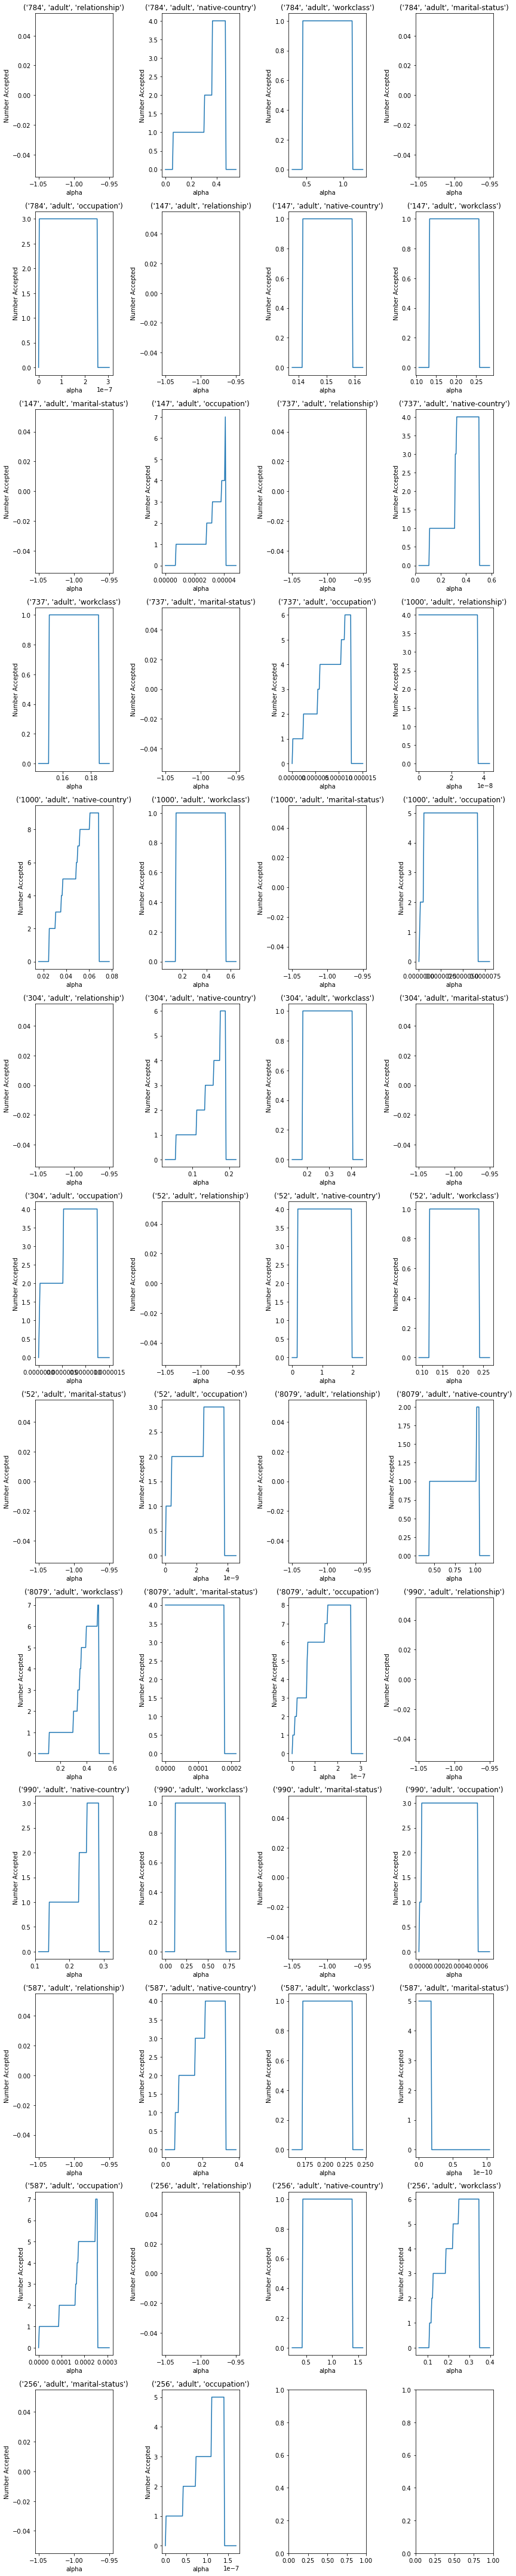

In [15]:
#matplotlib.rcParams.update({'font.size': 12})
NCOLS = 4
NROWS = int(len(x_axis.keys())/NCOLS)
fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*3, NROWS*5))

for i, exp in enumerate(x_axis.keys()):  #Assume x_axis, y_axis keys are the same 
    axes[int(i/4), i%4].plot(x_axis[exp], y_axis[exp])
    axes[int(i/4), i%4].set_title(exp)
    axes[int(i/4), i%4].set_ylabel('Number Accepted')
    axes[int(i/4), i%4].set_xlabel('alpha')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()


# ALPHA SENSITIVITY PLOTS

##Regular

In [16]:
# colours = ['b', 'g', 'r', 'c', 'k']
# matplotlib.rcParams.update({'font.size': 16})
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

# for i, exp in enumerate(CPid_results.keys()):
#     sort_pcp_sens = norm_ctr(CPid_results[exp], 5)    
    
#     labels = []
#     bars = []
#     for d in range(min(5,len(sort_pcp_sens))):
#         labels.append(sort_pcp_sens[d][0])
#         bars.append(sort_pcp_sens[d][1])


#     X = 0 
#     width = 0.05  # the width of the bars
    
#     axes[int(i/4), i%4].set_title(exp, pad=30)
#     if (i%4) == 0:
#         axes[int(i/4), i%4].set_ylabel('Proportion Included', fontsize=32)
#         axes[int(i/4), i%4].yaxis.labelpad = 40
#     axes[int(i/4), i%4].set_ylim(0,1)
#     axes[int(i/4), i%4].tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the 
    
#     for d in range(len(labels)):
#         axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], width = width, label=labels[d])
#     axes[int(i/4), i%4].legend(loc='lower left', prop={'size':30}) 

# plt.show()

In [17]:
print(CPid_results.keys())

dict_keys([('784', 'adult', 'relationship'), ('784', 'adult', 'native-country'), ('784', 'adult', 'workclass'), ('784', 'adult', 'marital-status'), ('784', 'adult', 'occupation'), ('147', 'adult', 'relationship'), ('147', 'adult', 'native-country'), ('147', 'adult', 'workclass'), ('147', 'adult', 'marital-status'), ('147', 'adult', 'occupation'), ('737', 'adult', 'relationship'), ('737', 'adult', 'native-country'), ('737', 'adult', 'workclass'), ('737', 'adult', 'marital-status'), ('737', 'adult', 'occupation'), ('1000', 'adult', 'relationship'), ('1000', 'adult', 'native-country'), ('1000', 'adult', 'workclass'), ('1000', 'adult', 'marital-status'), ('1000', 'adult', 'occupation'), ('304', 'adult', 'relationship'), ('304', 'adult', 'native-country'), ('304', 'adult', 'workclass'), ('304', 'adult', 'marital-status'), ('304', 'adult', 'occupation'), ('52', 'adult', 'relationship'), ('52', 'adult', 'native-country'), ('52', 'adult', 'workclass'), ('52', 'adult', 'marital-status'), ('52',

##Aggregate Random Seeds

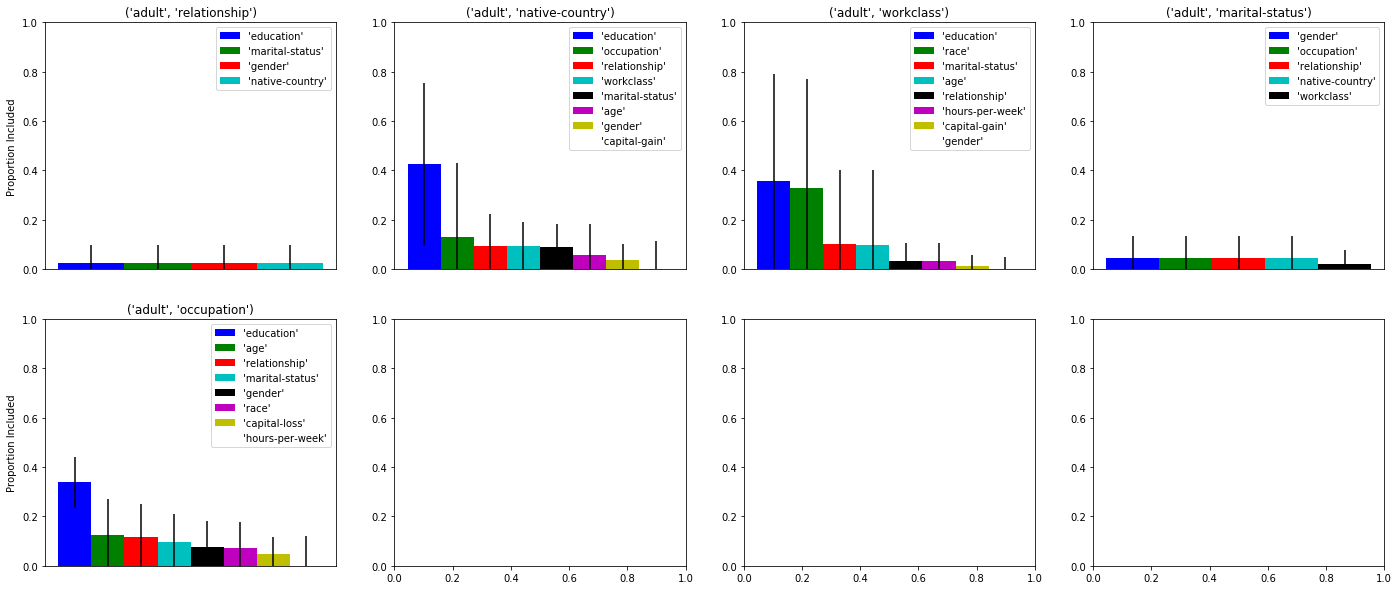

In [18]:
colours = ['b', 'g', 'r', 'c', 'k', 'm', 'y', 'w']
# matplotlib.rcParams.update({'font.size': 16})

NCOLS = 4
NROWS = int(len(list(itertools.product(dataset, environment)))/NCOLS)
fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*6, NROWS*10))

for i, big_exp in enumerate(list(itertools.product(dataset, environment))):
    avg_sort_pcp_sens = mean_slist(eligible_exps(big_exp, CPid_results.keys()), CPid_results)
    errors = var_slist(eligible_exps(big_exp, CPid_results.keys()), CPid_results)
    
    labels = []
    bars = []
    errors_plt = []
    for d in range(min(8,len(avg_sort_pcp_sens))):
        labels.append(avg_sort_pcp_sens[d][0])
        bars.append(avg_sort_pcp_sens[d][1])
        errors_plt.append(errors[d][1])

    X = 0 
    width = 0.05  # the width of the bars

    axes[int(i/4), i%4].set_title(big_exp)  #, pad=30)
    if (i%4) == 0:
        axes[int(i/4), i%4].set_ylabel('Proportion Included') #, fontsize=32)
        axes[int(i/4), i%4].yaxis.labelpad = 5
    axes[int(i/4), i%4].set_ylim(0,1)
    axes[int(i/4), i%4].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the 

    for d in range(len(labels)):
        axes[int(i/4), i%4].bar(X + (d*width), bars[d], color = colours[d], \
                                width = width, label=labels[d], yerr=errors_plt[d])
    axes[int(i/4), i%4].legend(loc='upper right')  #, prop={'size':30}) 

plt.show()

## Confusion Matrix

In [19]:
all_consmats = []  #consmats for all (dataset, seed) combos

#Get the consistency matrix for each seed
for big_exp in list(itertools.product(dataset, seed)):  #enumerates through each random seed 
    env_exps = eligible_exps(big_exp, CPid_results.keys())
    res = np.zeros([len(environment), len(environment)])
    for i, env_1 in enumerate(env_exps):
        for j, env_2 in enumerate(env_exps):
            if i <= j:
                e1 = set([x[0] for x in norm_ctr(CPid_results[env_1], 5)])
                e2 = set([x[0] for x in norm_ctr(CPid_results[env_2], 5)])
                #Jaccard
                if (len(set.intersection(e1, e2)) == 0) and (len(set.union(e1, e2)) == 0):
                    res[i,j] = 1
                else:
                    res[i,j] = len(set.intersection(e1, e2))/len(set.union(e1, e2))

    all_consmats.append(res)

#Compute mean, variance of consistency matrix 
mean_consmat = (sum(all_consmats)/len(all_consmats)).round(decimals=2)
std_consmat = np.zeros([len(environment), len(environment)])
for cm in all_consmats:
    std_consmat += np.square((cm - mean_consmat))
std_consmat = np.sqrt(std_consmat/len(all_consmats)).round(decimals=2)

consmat = pd.DataFrame(mean_consmat, index=environment, columns=environment).applymap(str).apply( \
              lambda x: x + ' +- ') + pd.DataFrame(std_consmat, index=environment, columns=environment).applymap(str)  
consmat.style





,relationship,native-country,workclass,marital-status,occupation
relationship,1.0 +- 0.0,0.03 +- 0.09,0.02 +- 0.08,0.7 +- 0.46,0.05 +- 0.15
native-country,0.0 +- 0.0,1.0 +- 0.0,0.11 +- 0.12,0.03 +- 0.09,0.27 +- 0.16
workclass,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.03 +- 0.09,0.25 +- 0.11
marital-status,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.04 +- 0.08
occupation,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0
